In [91]:
# uni_D83AE5_uni (Baseline)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from scipy.stats import gamma, kstest
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    log_loss, 
    roc_auc_score, 
    roc_curve, 
    auc
)
import statsmodels.api as sm
import warnings

warnings.filterwarnings('ignore')  # Use this line to suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

training_data = pd.read_csv('training_data.csv')
training_data = training_data[training_data['BORROWER_ID'] != 'xNullx']
training_data = training_data.sample(frac=1, random_state=42).reset_index(drop=True)
data_submission_example = pd.read_csv('data_submission_example.csv')

In [92]:
training_data.fillna(0, inplace=True)
for col in training_data.columns:
    try:
        training_data[col] = pd.to_numeric(training_data[col], errors='ignore')
    except:
        continue
training_data['TARGET_EVENT_BINARY'] = np.where(training_data['TARGET_EVENT'] == 'K', 1, 0)

In [93]:
lognormal_variables = [
    'CONTRACT_CREDIT_LOSS', 'CONTRACT_DEPT_SERVICE_TO_INCOME',
    'CONTRACT_INCOME', 'CONTRACT_INSTALMENT_AMOUNT', 'CONTRACT_INSTALMENT_AMOUNT_2',
    'CONTRACT_LOAN_AMOUNT', 'CONTRACT_MARKET_VALUE', 'CONTRACT_MORTGAGE_LENDING_VALUE', 
    'CONTRACT_LGD', 'CONTRACT_INCOME'
]
date_variables = ['CONTRACT_DATE_OF_LOAN_AGREEMENT', 'CONTRACT_MATURITY_DATE']

In [94]:
training_data['TARGET_EVENT_DAY'].replace(0.0, np.nan, inplace=True)
training_data['TARGET_EVENT_DAY_JULIAN'] = pd.to_datetime(training_data['TARGET_EVENT_DAY'], origin='julian', unit='D', errors='coerce')
training_data['TARGET_EVENT_DAY_DATETIME'] = pd.to_datetime(training_data['TARGET_EVENT_DAY_JULIAN'],  errors='coerce')

training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN'] = pd.to_datetime(training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT'], origin='julian', unit='D')
training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] = pd.to_datetime(training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN'],)

training_data['CONTRACT_MATURITY_DATE_JULIAN'] = pd.to_datetime(training_data['CONTRACT_MATURITY_DATE'], origin='julian', unit='D')
training_data['CONTRACT_MATURITY_DATE_DATETIME'] = pd.to_datetime(training_data['CONTRACT_MATURITY_DATE_JULIAN'])

In [95]:
training_data['DAY_DIFF'] = (training_data['TARGET_EVENT_DAY_DATETIME'] - training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME']).dt.days

In [96]:
def create_binary_target_column(dataframe, column_name, event, day_diff_upper_limit):
    dataframe[column_name] = np.where(
        (dataframe['TARGET_EVENT'] == event) & 
        (dataframe['DAY_DIFF'] <= day_diff_upper_limit) & 
        (dataframe['DAY_DIFF'] >= 0), 
        1, 
        0
    )

timeframes = {
    'TARGET_EVENT_BINARY_2Y': 730,
    'TARGET_EVENT_BINARY_1Y': 365,
    'TARGET_EVENT_BINARY_6M': 365//2,
}

for column_name, days in timeframes.items():
    create_binary_target_column(training_data, column_name, 'K', days)


target_event_binary_columns = []
for i in range(26):
    start_day = 273 + i * 30
    column_header = 'TARGET_EVENT_BINARY_' + str(start_day) + 'D'
    training_data[column_header] = np.where(
        (training_data['TARGET_EVENT'] == 'K') & 
        (training_data['DAY_DIFF'] <= start_day) & 
        (training_data['DAY_DIFF'] >= 0), 
        1, 
        0
    )
    target_event_binary_columns.append(column_header)


In [97]:
from datetime import datetime
current_date = datetime.strptime('2018-01-01', '%Y-%m-%d')
training_data['DAY_DIFF'].fillna((current_date - training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME']).dt.days, inplace=True)

In [98]:
negative_count = (training_data['DAY_DIFF'] < 0).sum()
print(f"Number of negative values: {negative_count}")
training_data.loc[training_data['DAY_DIFF'] < 0, 'DAY_DIFF'] = 1

end_date = datetime.strptime('2020-01-01', '%Y-%m-%d')
training_data['DAY_TO_END'] = (end_date - training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME']).dt.days

Number of negative values: 68


In [99]:
numeric_columns = training_data.select_dtypes(include=[np.number]).columns.tolist()
excluded_keywords = ['TARGET', 'event', 'binary', 'DATE', 'DAY']

X_columns = [col for col in numeric_columns if all(keyword.lower() not in col.lower() for keyword in excluded_keywords)]
y_column = 'TARGET_EVENT_BINARY_2Y' 
X_columns

['CONTRACT_CREDIT_INTERMEDIARY',
 'CONTRACT_CREDIT_LOSS',
 'CONTRACT_CURRENCY',
 'CONTRACT_DEPT_SERVICE_TO_INCOME',
 'CONTRACT_INCOME',
 'CONTRACT_INSTALMENT_AMOUNT',
 'CONTRACT_INSTALMENT_AMOUNT_2',
 'CONTRACT_INTEREST_PERIOD',
 'CONTRACT_INTEREST_RATE',
 'CONTRACT_LGD',
 'CONTRACT_LOAN_AMOUNT',
 'CONTRACT_LOAN_CONTRACT_TYPE',
 'CONTRACT_LOAN_TO_VALUE_RATIO',
 'CONTRACT_MARKET_VALUE',
 'CONTRACT_MORTGAGE_LENDING_VALUE',
 'CONTRACT_MORTGAGE_TYPE',
 'CONTRACT_REFINANCED',
 'CONTRACT_RISK_WEIGHTED_ASSETS',
 'CONTRACT_TYPE_OF_INTEREST_REPAYMENT',
 'BORROWER_BIRTH_YEAR',
 'BORROWER_CITIZENSHIP',
 'BORROWER_COUNTRY',
 'BORROWER_COUNTY',
 'BORROWER_TYPE_OF_SETTLEMENT']

In [100]:
loan_type_dummies = pd.get_dummies(training_data['CONTRACT_LOAN_TYPE'], prefix='LOAN_TYPE', drop_first=True)
frequency_type_dummies = pd.get_dummies(training_data['CONTRACT_FREQUENCY_TYPE'], prefix='FREQ_TYPE', drop_first=True)
training_data = pd.concat([training_data, loan_type_dummies, frequency_type_dummies], axis=1)

X_columns.extend(loan_type_dummies.columns)
X_columns.extend(frequency_type_dummies.columns)

In [101]:
training_data['BORROWER_LOAN_COUNT'] = training_data.groupby('BORROWER_ID')['BORROWER_ID'].transform('count')
training_data['LOAN_BORROWER_COUNT'] = training_data.groupby('CONTRACT_ID')['CONTRACT_ID'].transform('count')
training_data['TOTAL_LOAN_AMOUNT'] = training_data.groupby('BORROWER_ID')['CONTRACT_LOAN_AMOUNT'].transform('sum')
training_data['TOTAL_INSTALLMENT_AMOUNT_1'] = training_data.groupby('BORROWER_ID')['CONTRACT_INSTALMENT_AMOUNT'].transform('sum')
training_data['TOTAL_INSTALLMENT_AMOUNT_2'] = training_data.groupby('BORROWER_ID')['CONTRACT_INSTALMENT_AMOUNT_2'].transform('sum')
training_data['TOTAL_INSTALLMENT_AMOUNT'] = training_data['TOTAL_INSTALLMENT_AMOUNT_1'] + training_data['TOTAL_INSTALLMENT_AMOUNT_2']

X_columns.extend(['BORROWER_LOAN_COUNT', 'TOTAL_LOAN_AMOUNT','TOTAL_INSTALLMENT_AMOUNT','LOAN_BORROWER_COUNT'])
lognormal_variables.extend([ 'TOTAL_LOAN_AMOUNT','TOTAL_INSTALLMENT_AMOUNT'])

In [102]:
threshold = 0.85
correlation_matrix = training_data[X_columns].corr()
highly_correlated_set = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated_set.add(colname)

X_columns = [col for col in X_columns if col not in highly_correlated_set]
print('Variables removed:', highly_correlated_set)

Variables removed: {'BORROWER_COUNTRY', 'FREQ_TYPE_2f88e16c', 'CONTRACT_REFINANCED'}


In [103]:
def train_and_predict_two_halves(df, variables, target, model1=LogisticRegression(), scaler=StandardScaler()):
    if lognormal_variables is not None:
        df = df.copy()
        
        for var in lognormal_variables:
            if var == 'CONTRACT_CREDIT_LOSS':
                df[var] = np.log1p(np.abs(df[var]))*np.sign(df[var])
            else:
                df[var] = np.log1p(df[var])
    

    X_scaled = scaler.fit_transform(df[variables])
    y = df[target]
    model1.fit(X_scaled, y)
    proba = model1.predict_proba(X_scaled)[:, 1]
    return proba

In [104]:
def eval_model(df, variables, target, model1=LogisticRegression(), scaler=StandardScaler()):
    if lognormal_variables is not None:
        df = df.copy()
        
        for var in lognormal_variables:
            if var == 'CONTRACT_CREDIT_LOSS':
                df[var] = np.log1p(np.abs(df[var]))
            else:
                df[var] = np.log1p(df[var])

    half = len(df) // 2
    df1, df2 = df.iloc[:half], df.iloc[half:]
    X_scaled = scaler.fit_transform(df[variables])
    X1_scaled = scaler.transform(df1[variables])
    X2_scaled = scaler.transform(df2[variables])
    y1 = df1[target]
    y2 = df2[target]
    model1.fit(X1_scaled, y1)
    y2_prob = model1.predict_proba(X2_scaled)[:, 1]
    print("Evaluation of Model 1 on df2:")
    print("Classification Report:")
    print(classification_report(y2, y2_prob >= 0.5))
    print("Log Loss:")
    print(log_loss(y2, y2_prob))
    print("Confusion Matrix:")
    print(confusion_matrix(y2, y2_prob >= 0.5))
    
    return log_loss(y2, y2_prob)

In [111]:
# import numpy as np
# from lifelines import CoxPHFitter


# def predict_default_within_two_years(df, variables, duration_col, event_col,):
#     df = df.copy()
#     if lognormal_variables is not None:
        
        
#         for var in lognormal_variables:
#             if var == 'CONTRACT_CREDIT_LOSS':
#                 df[var] = np.log1p(np.abs(df[var]))
#             else:
#                 df[var] = np.log1p(df[var])
    
#     model = CoxPHFitter(penalizer=100)

#     model.fit(df[variables + [duration_col, event_col]], duration_col=duration_col, event_col=event_col, show_progress=True)
    
#     n = len(df)
#     batch_size = 100
#     prob_defaults = np.zeros(n)

#     for i in range(0, n, batch_size):
#         print(i)
#         start, end = i, min(i + batch_size, n)
#         batch_df = df[start:end]
#         survival_function = model.predict_survival_function(batch_df[variables], times=batch_df['DAY_TO_END'])
#         prob_defaults[start:end] = 1 - survival_function.iloc[0].values

#     df['prob_default'] = prob_defaults

#     return df[['prob_default']]
#     # return 1
# # Example usage:
# # Assume model is already fitted, if not, it will be fitted inside the function.
# predicted_defaults = predict_default_within_two_years(training_data, variables=X_columns, duration_col='DAY_DIFF', event_col='TARGET_EVENT_BINARY', )

from lifelines import CoxPHFitter
import numpy as np
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import matplotlib.pyplot as plt
import seaborn as sns

# Custom wrapper for CoxPHFitter to work with CalibratedClassifierCV
class CoxPHWrapper:
    def __init__(self, cox_model):
        self.cox_model = cox_model
    
    def fit(self, X, y):
        # Fit the Cox model - assuming 'y' contains both duration and event columns
        self.cox_model.fit(X, 'DAY_DIFF', 'TARGET_EVENT_BINARY', show_progress=True)
        return self

    def predict_proba(self, X):
        # This will return a matrix of survival probabilities for each time point
        # We will just return the last time point as the "probability of survival"
        survival_probs = self.cox_model.predict_survival_function(X).iloc[-1].values
        # Return the probabilities in the format [1 - p, p]
        return np.vstack([1 - survival_probs, survival_probs]).T

# Adapt the function to use the wrapped Cox model for calibration
def predict_default_within_two_years(df, variables, duration_col, event_col, lognormal_variables=None):
    df = df.copy()
    if lognormal_variables is not None:
        for var in lognormal_variables:
            if var == 'CONTRACT_CREDIT_LOSS':
                df[var] = np.log1p(np.abs(df[var]))
            else:
                df[var] = np.log1p(df[var])
    
    model = CoxPHFitter(penalizer=100)

    # Wrap the Cox model
    wrapped_cox = CoxPHWrapper(model)

    # Fit the Cox model
    wrapped_cox.fit(df[variables + [duration_col, event_col]], df[[duration_col, event_col]])
    
    # Calibrate the Cox model
    calibrated_cox = CalibratedClassifierCV(base_estimator=wrapped_cox, method='sigmoid')
    calibrated_cox.fit(df[variables], df[event_col])

    # Now we can use predict_proba to get the calibrated probabilities
    prob_defaults = calibrated_cox.predict_proba(df[variables])[:, 1]

    df['prob_default'] = prob_defaults

    return df[['prob_default']]

# Example usage:
# Assume df is your dataframe, and you have your variables set up.
predicted_defaults = predict_default_within_two_years(training_data, variables=X_columns, duration_col='DAY_DIFF', event_col='TARGET_EVENT_BINARY', )


KeyError: None

In [106]:
training_data['DAY_DIFF']

0          410.0
1          215.0
2          837.0
3          566.0
4          713.0
           ...  
1601658    107.0
1601659    604.0
1601660    439.0
1601661    774.0
1601662    171.0
Name: DAY_DIFF, Length: 1601663, dtype: float64

<Axes: >

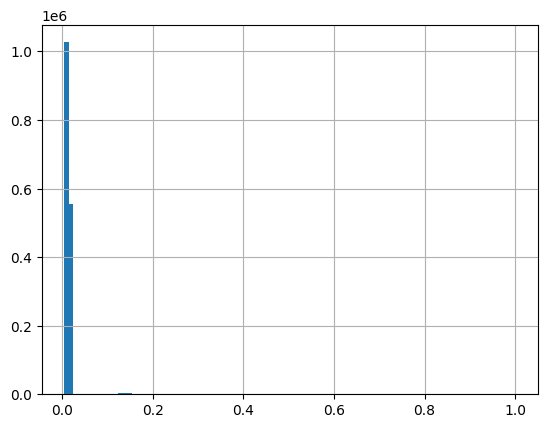

In [ ]:
predicted_defaults['prob_default'].hist(bins=100)

In [ ]:
predicted_defaults.mean()

prob_default    0.014916
dtype: float64

In [82]:
training_data['COX_PROBA'] = predicted_defaults['prob_default']
submission = create_submission_file(training_data, 'COX_PROBA', data_submission_example, filename='./predictions/cox.csv')

Before centering:
0.285384650850823 0.01007718188360296 0.019661948685070218
Centering probabilities...
0.28052270216575276 0.005215233198532742 0.014799999999999987
Saved file: ./predictions/cox.csv


In [49]:
def combined_probability(s):
    if len(s) == 2:
        p_a, p_b = s.values
        return p_a + p_b - p_a * p_b - (-3.2357827075016176e-05)
    else:
        return 1 - np.prod(1 - s.values)

def create_submission_file(df_preds, target, example, filename='submission.csv', testing=False):
    # Filter the data to only include BORROWER_IDs that are in the submission example
    filtered_training_data = df_preds[df_preds['BORROWER_ID'].isin(example['BORROWER_ID'])]

    # Print warning if the row count is off
    if not testing and len(filtered_training_data) != 1564601:
        print('WARNING: The filtered data does not have the correct number of rows. Make sure you are not using the training data for submission.')
        # raise ValueError('WARNING: The submission file does not have the correct number of rows. Make sure you are not using the training data for submission.')
    # Group by BORROWER_ID and calculate the combined probability

    #######################x########################
    #CUTTING TAILS DID NOT SEEM TO WORK
    #######################x########################
    # filtered_training_data = cut_exponential_tails(filtered_training_data, target)
    grouped_data = filtered_training_data.groupby('BORROWER_ID')[target].apply(combined_probability).reset_index()

    # Create the submission DataFrame
    df_submission = pd.DataFrame()
    df_submission['BORROWER_ID'] = grouped_data['BORROWER_ID']
    df_submission['PRED'] = grouped_data[target]
    print('Before centering:')
    print(df_submission['PRED'].max(), df_submission['PRED'].min(), df_submission['PRED'].mean())

    print('Centering probabilities...')
    # Center the probabilities around 1.48%
    desired_mean = 0.0148  # 1.48% as a decimal
    while (df_submission['PRED'].max() > 1 or df_submission['PRED'].min() < 0 or abs(df_submission['PRED'].mean() -0.0148) > 0.0005):
        # print(df_submission['PRED'].max(), df_submission['PRED'].min(), df_submission['PRED'].mean())
        df_submission['PRED'] = df_submission['PRED'].clip(lower=0, upper=1)
        # print(df_submission['PRED'].max(), df_submission['PRED'].min(), df_submission['PRED'].mean())

        current_mean = df_submission['PRED'].mean()
        adjustment_factor = desired_mean  - current_mean
        df_submission['PRED'] += adjustment_factor
    print(df_submission['PRED'].max(), df_submission['PRED'].min(), df_submission['PRED'].mean())
    # Save the submission file
    if  not testing and filename is not None:
        df_submission.to_csv(filename, index=False)
    print(f'Saved file: {filename}')
    # if abs(df_submission['PRED'].mean() -0.0148) > 0.0005:
    #    raise ValueError('WARNING: mean is bad')
        
    # Print warning if the row count is off
    if not testing and len(df_submission) != 1117674:
        print('WARNING: The submission file does not have the correct number of rows. Make sure you are not using the training data for submission.')
        # raise ValueError('WARNING: The submission file does not have the correct number of rows. Make sure you are not using the training data for submission.')
        
    return df_submission


In [50]:
def test_model_2y_1y(df, variables, target, model1=LogisticRegression(), model2=LogisticRegression()):
    df = df.copy()
    start_date = pd.Timestamp('2015-01-01')
    end_date = pd.Timestamp('2017-01-01')

    # Mask for rows with CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN between start_date and end_date
    mask_date_range = (df['CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN'] >= start_date) & (df['CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN'] <= end_date)

    df = df[mask_date_range]

    probs = train_and_predict_two_halves(
        df, 
        variables, 
        target, 
        model1=model1,
        model2=model2,
    )
    df['2Y-1Y-PROBS'] = probs
    
    test_data = pd.read_csv('./data/1y-test.csv')


    df_submission = create_submission_file(df, '2Y-1Y-PROBS', test_data, filename=None, testing=True)

    merged_df = pd.merge(test_data, df_submission, on='BORROWER_ID')
    true_labels = merged_df['TARGET_EVENT_BINARY_1Y']
    predicted_probs = merged_df['PRED']
    logloss = log_loss(true_labels, predicted_probs)

    print(f'Log loss: {logloss}')
        
    return logloss

In [46]:
def significant_features(df, variables, target, model1=LogisticRegression(), scaler=StandardScaler()):
    if lognormal_variables is not None:
        df = df.copy()
        
        for var in lognormal_variables:
            if var == 'CONTRACT_CREDIT_LOSS':
                df[var] = np.log1p(np.abs(df[var]))*np.sign(df[var])
            else:
                df[var] = np.log1p(df[var])

    X_scaled = scaler.fit_transform(df[variables])

    X = sm.add_constant(pd.DataFrame(X_scaled, columns=variables))
    y = df[target]
    model = sm.Logit(y, X).fit()
    print(model.summary())
    p_values = model.pvalues
    non_significant_vars = p_values[p_values > 0.05].index.tolist()

    return model, non_significant_vars

In [31]:
# significant_features(training_data, X_columns, y_column)

                             Logit Regression Results                             
Dep. Variable:     TARGET_EVENT_BINARY_2Y   No. Observations:              1601663
Model:                              Logit   Df Residuals:                  1601613
Method:                               MLE   Df Model:                           49
Date:                    Mon, 06 Nov 2023   Pseudo R-squ.:                  0.5932
Time:                            00:53:11   Log-Likelihood:                -24526.
converged:                          False   LL-Null:                       -60284.
Covariance Type:                nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.4383   1765.722     -0.006      0.995   -3471.189    3450.313
x1            -0.0077      0.004     -1.790      0.074      -0.016       0.001
x2             4.826

c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\discrete\discrete_model.py:1074: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\discrete\discrete_model.py:1567: RuntimeWarning: overflow encountered in exp
  L = np.exp(np.dot(X,params) + exposure + offset)
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\discrete\discrete_model.py:1478: RuntimeWarning: overflow encountered in exp
  L = np.exp(np.dot(X,params) + offset + exposure)


KeyboardInterrupt: 

In [17]:
non_significant_vars

['const',
 'CONTRACT_CREDIT_INTERMEDIARY',
 'CONTRACT_LOAN_AMOUNT',
 'BORROWER_COUNTY',
 'LOAN_TYPE_1f951336',
 'LOAN_TYPE_2f88e16c',
 'LOAN_TYPE_47693941',
 'LOAN_TYPE_5a06241e',
 'LOAN_TYPE_694cbaee',
 'LOAN_TYPE_69f70539',
 'LOAN_TYPE_7e2065f4',
 'LOAN_TYPE_83910425',
 'LOAN_TYPE_8fe006f1',
 'LOAN_TYPE_955ae3ef',
 'LOAN_TYPE_95c4f8fb',
 'LOAN_TYPE_b503a0de',
 'LOAN_TYPE_cde77491',
 'LOAN_TYPE_cf07c2dd',
 'LOAN_TYPE_d3aaffde',
 'LOAN_TYPE_eab72d7a',
 'LOAN_TYPE_f792971b',
 'FREQ_TYPE_89efd382',
 'FREQ_TYPE_bd092d5a']

In [18]:
X_columns.remove('CONTRACT_CREDIT_INTERMEDIARY')
X_columns.remove('BORROWER_COUNTY')

In [19]:
# 0.006785876080349979
# Before centering:
# 0.9978858840423693 8.548717289613705e-15 0.006063585227926563
# Centering probabilities...
# 1.0 0.008736424229876956 0.01479999999999999
# Saved file: ./predictions/logistic-regression-one-model.csv
predicted_probs = 'LOGISTIC_REG'
probs = train_and_predict_two_halves(
    training_data, 
    X_columns, 
    y_column, 
    model1=LogisticRegression(max_iter=400, C=1, random_state=42),
)
training_data[predicted_probs] = probs
print(probs.mean())
submission = create_submission_file(training_data, predicted_probs, data_submission_example, filename='./predictions/logistic-regression-one-model.csv')

0.00618867977565601
Before centering:
0.9972695060305609 2.220446049250313e-15 0.00552425424963605
Centering probabilities...
1.0 0.00927575160650816 0.014799999999999999
Saved file: ./predictions/logistic-regression-one-model.csv


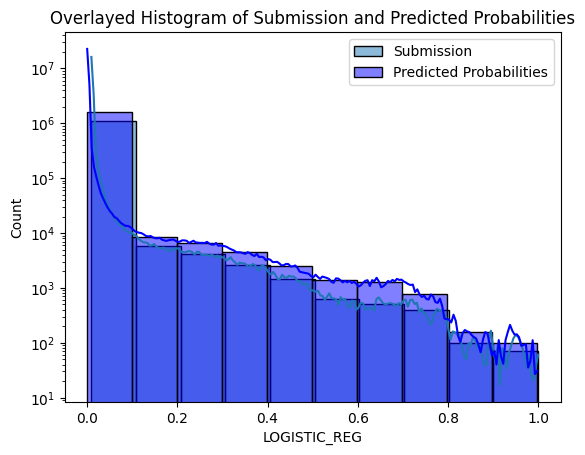

In [20]:
sns.histplot(submission, bins=10, kde=True, label='Submission', alpha=0.5,color='red')
sns.histplot(training_data['LOGISTIC_REG'], bins=10, kde=True, label='Predicted Probabilities', alpha=0.5, color='blue')
plt.yscale('log')
plt.legend()
plt.title('Overlayed Histogram of Submission and Predicted Probabilities')
plt.show()

In [21]:
for c_param in np.linspace(0.1, 1, 10):
    print(f'C={c_param}')
    eval_model(training_data, X_columns, y_column, model1=LogisticRegression(max_iter=400, C=c_param, random_state=42))

C=0.1
Evaluation of Model 1 on df2:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    795912
           1       0.54      0.19      0.28      4920

    accuracy                           0.99    800832
   macro avg       0.77      0.59      0.64    800832
weighted avg       0.99      0.99      0.99    800832

Log Loss:
0.015231114096998557
Confusion Matrix:
[[795107    805]
 [  3985    935]]
C=0.2
Evaluation of Model 1 on df2:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    795912
           1       0.53      0.19      0.28      4920

    accuracy                           0.99    800832
   macro avg       0.76      0.60      0.64    800832
weighted avg       0.99      0.99      0.99    800832

Log Loss:
0.015225995298282854
Confusion Matrix:
[[795088    824]
 [  3974    946]]
C=0.30000000000000004
Evaluation of Model 1 on df2:
Classifi

In [22]:
def calculate_probabilities(data, column, time_factor):
    lambdas = -np.log(1 - data[column]) / time_factor
    probs_2y = 1 - np.exp(-2 * lambdas)
    return probs_2y

In [120]:
time_periods = {
    '1Y': 1,
    # '18M': 1.5,
    # '9M': 0.75,
    '6M': 0.5
}
for suffix, time_factor in time_periods.items():
    logistic_model = LogisticRegression(max_iter=400, C=1)
    print(f"2Y-{suffix}")
    probs = train_and_predict_two_halves(
        training_data, 
        X_columns, 
        f'TARGET_EVENT_BINARY_{suffix}', 
        model1=logistic_model
    )
    training_data[f'LOGISTIC_REG_{suffix}'] = probs
    training_data[f'{suffix}_PROBA'] = calculate_probabilities(training_data, f'LOGISTIC_REG_{suffix}', time_factor)

2Y-1Y
2Y-6M


In [124]:
training_data['1Y_PROBA'].mean()

0.005336191839808799

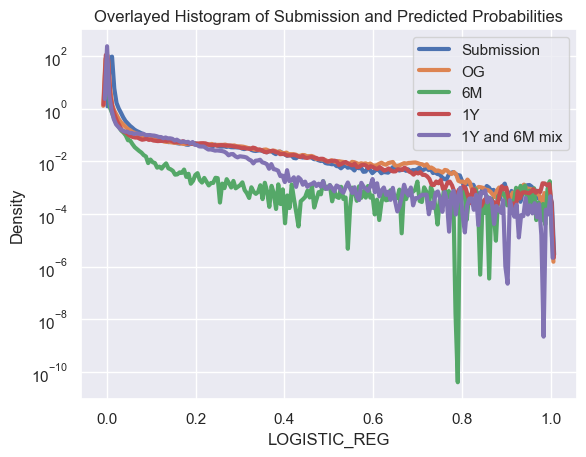

In [122]:
sns.kdeplot(submission, label='Submission', lw=3, alpha=1)
sns.kdeplot(training_data['LOGISTIC_REG'], label='OG', lw=3, alpha=1)
sns.kdeplot(training_data['6M_PROBA'], label='6M', lw=3, alpha=1)
sns.kdeplot(training_data['1Y_PROBA'], label='1Y', lw=3, alpha=1)
sns.kdeplot(training_data['1Y_PROBA']*0.5+training_data['6M_PROBA']*0.5, label='1Y and 6M mix', lw=3, alpha=1)

plt.yscale('log')
plt.legend()
plt.title('Overlayed Histogram of Submission and Predicted Probabilities')
plt.show()

0.014810940173227698 0.9999999966674054 5.551115123125783e-15 0.0884959510283018


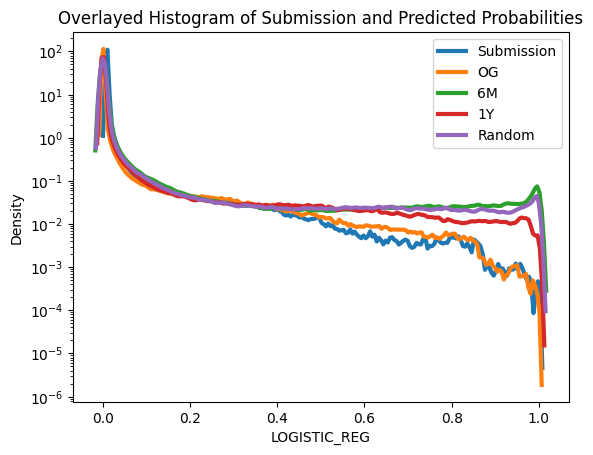

In [22]:
experiment_probs = calculate_probabilities(training_data, 'LOGISTIC_REG_6M', 0.585)
print(experiment_probs.mean(), experiment_probs.max(), experiment_probs.min(), experiment_probs.std())
sns.kdeplot(submission, label='Submission', lw=3, alpha=1)
sns.kdeplot(training_data['LOGISTIC_REG'], label='OG', lw=3, alpha=1)
sns.kdeplot(training_data['6M_PROBA'], label='6M', lw=3, alpha=1)
sns.kdeplot(training_data['1Y_PROBA'], label='1Y', lw=3, alpha=1)
sns.kdeplot(experiment_probs, label='Random', lw=3, alpha=1)

plt.yscale('log')
plt.legend()
plt.title('Overlayed Histogram of Submission and Predicted Probabilities')
plt.show()

In [23]:
magic_number = 0.585
experiment_probs = calculate_probabilities(training_data, 'LOGISTIC_REG_6M', magic_number)
print(experiment_probs.mean(), experiment_probs.max(), experiment_probs.min(), experiment_probs.std())
training_data['EXPERIMENT_PROBS'] = experiment_probs
submission_exp = create_submission_file(training_data, 'EXPERIMENT_PROBS', data_submission_example, filename='./predictions/prediction-with-time-param-0-585.csv')

0.015575901439723577 0.9999999994255928 6.106226635438361e-15 0.09162013689902006
Before centering:
1.0000323361576025 2.919886554764162e-14 0.014797564788727033
Centering probabilities...
1.0 2.435324307306988e-06 0.014799999999999995
Saved file: ./predictions/prediction-with-time-param-0-585.csv


In [25]:
# submission_1y_2y = create_submission_file(training_data, '2Y_PROBA', data_submission_example, filename='./predictions/logistic-regression-2y-1y.csv')

Before centering:
0.9999955305137177 1.709743457922741e-14 0.010279658216347512
Centering probabilities...
1.0 0.00452043496900666 0.014800000000000002
Saved file: ./predictions/logistic-regression-2y-1y.csv


In [156]:
probs = np.array(0)
probs.mean()

0.0

In [65]:
for target_day in target_event_binary_columns:
    probs = train_and_predict_two_halves(
    training_data, 
    X_columns, 
    target_day, 
    model1=LogisticRegression(max_iter=400, C=1),
    )
    training_data[target_day+'_PROBS'] = probs
    print(f"Done with {target_day}")

Done with TARGET_EVENT_BINARY_273D
Done with TARGET_EVENT_BINARY_303D
Done with TARGET_EVENT_BINARY_333D
Done with TARGET_EVENT_BINARY_363D
Done with TARGET_EVENT_BINARY_393D
Done with TARGET_EVENT_BINARY_423D
Done with TARGET_EVENT_BINARY_453D
Done with TARGET_EVENT_BINARY_483D
Done with TARGET_EVENT_BINARY_513D
Done with TARGET_EVENT_BINARY_543D
Done with TARGET_EVENT_BINARY_573D
Done with TARGET_EVENT_BINARY_603D
Done with TARGET_EVENT_BINARY_633D
Done with TARGET_EVENT_BINARY_663D
Done with TARGET_EVENT_BINARY_693D
Done with TARGET_EVENT_BINARY_723D
Done with TARGET_EVENT_BINARY_753D
Done with TARGET_EVENT_BINARY_783D
Done with TARGET_EVENT_BINARY_813D
Done with TARGET_EVENT_BINARY_843D
Done with TARGET_EVENT_BINARY_873D
Done with TARGET_EVENT_BINARY_903D
Done with TARGET_EVENT_BINARY_933D
Done with TARGET_EVENT_BINARY_963D
Done with TARGET_EVENT_BINARY_993D
Done with TARGET_EVENT_BINARY_1023D


In [66]:
reference_proba =  0.015575901439723577
for target_day in target_event_binary_columns:
    day_str = target_event_binary_columns[0].split('_')[-1].split('D')[0]
    day_int = int(day_str)
    # probs = np.array(0)
    # while abs(probs.mean()-reference_proba) > 0.0005 and probs.mean() < reference_proba :
    #     lambdas = -np.log(1 - training_data[target_day+'_PROBS'])/day_int*365
    #     probs = 1 - np.exp(-2 * lambdas)
    #     day_int -= 1
    #     if day_int < 0:
    #         print("ERROR")
    #         break
    lambdas = -np.log(1 - training_data[target_day+'_PROBS'])/day_int*365
    probs = 1 - np.exp(-2 * lambdas)
    
    print(f'Proba at {target_day}')
    print(probs.mean())
    training_data[target_day + '_2Y_LAMBDA'] = lambdas
    training_data[target_day + '_2Y_PROBS'] = probs


Proba at TARGET_EVENT_BINARY_273D
0.0034171324249781254
Proba at TARGET_EVENT_BINARY_303D
0.004409290671784856
Proba at TARGET_EVENT_BINARY_333D
0.005592436700329334
Proba at TARGET_EVENT_BINARY_363D
0.006619363403251891
Proba at TARGET_EVENT_BINARY_393D
0.00750726038840091
Proba at TARGET_EVENT_BINARY_423D
0.008256097607836852
Proba at TARGET_EVENT_BINARY_453D
0.008921234534009254
Proba at TARGET_EVENT_BINARY_483D
0.00965063299697378
Proba at TARGET_EVENT_BINARY_513D
0.010154303589274076
Proba at TARGET_EVENT_BINARY_543D
0.010598341767699655
Proba at TARGET_EVENT_BINARY_573D
0.011053726860036412
Proba at TARGET_EVENT_BINARY_603D
0.011431050485216261
Proba at TARGET_EVENT_BINARY_633D
0.011743426321285222
Proba at TARGET_EVENT_BINARY_663D
0.012035584366456725
Proba at TARGET_EVENT_BINARY_693D
0.012278665180797477
Proba at TARGET_EVENT_BINARY_723D
0.0124537672000849
Proba at TARGET_EVENT_BINARY_753D
0.012647372056411458
Proba at TARGET_EVENT_BINARY_783D
0.01279250517828872
Proba at TARGE

In [67]:
probs_columns = [col + '_2Y_LAMBDA' for col in target_event_binary_columns[:1]]
training_data[probs_columns].mean()

TARGET_EVENT_BINARY_273D_2Y_LAMBDA    0.002061
dtype: float64

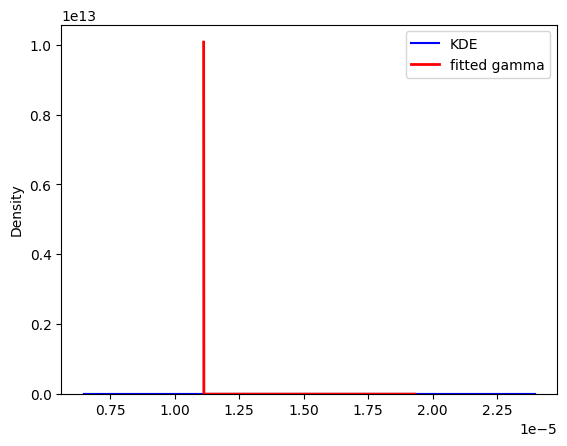

In [68]:
first_row_lambdas = [training_data[target_day + '_2Y_LAMBDA'].iloc[15025] for target_day in target_event_binary_columns]
sns.kdeplot(first_row_lambdas)
a, loc, scale = gamma.fit(first_row_lambdas)
x = np.linspace(min(first_row_lambdas), max(first_row_lambdas), 1000)
gamma_pdf = gamma.pdf(x, a, loc, scale)
sns.kdeplot(first_row_lambdas, color='blue', label='KDE')
plt.plot(x, gamma_pdf, 'r-', lw=2, label='fitted gamma')
plt.legend()
plt.show()

In [69]:
from scipy.stats import norm, kstest

a, loc, scale = gamma.fit(first_row_lambdas)
statistic, pvalue = kstest(first_row_lambdas, 'gamma', args=(a, loc, scale))
print(f"KS Statistic: {statistic}, P-value: {pvalue}")


mu, std = norm.fit(first_row_lambdas)
statistic, pvalue = kstest(first_row_lambdas, 'norm', args=(mu, std))
print(f"KS Statistic for Normal: {statistic}, P-value: {pvalue}")

KS Statistic: 0.3641569038536867, P-value: 0.0013470355064718609
KS Statistic for Normal: 0.1876206496093739, P-value: 0.2824489619090371


In [45]:
from scipy.integrate import quad

fit_results = []
probas = []
errors = []

def gamma_pdf(l, a, loc, scale):
    return gamma.pdf(l, a, loc, scale)
def integrand(l, a, loc, scale):
    return (1 - np.exp(-2*l)) * gamma_pdf(l, a, loc, scale)


for index, row in training_data.head(10000).iterrows():
    if (index+1) % 100 == 0:
        print(f"Done with {index} rows")
    
    first_row_lambdas = [row[target_day + '_2Y_LAMBDA'] for target_day in target_event_binary_columns]

    a, loc, scale = gamma.fit(first_row_lambdas)
    statistic, pvalue = kstest(first_row_lambdas, 'gamma', args=(a, loc, scale))
    if pvalue < 0.05:
        probas.append(row[target_event_binary_columns[-1] + '_2Y_PROBS'])
        fit_results.append((-1, -1, -1))
        errors.append(-1)   
        continue
    proba, error = quad(integrand, 0, np.inf, args=(a, loc, scale))
    fit_results.append((a, loc, scale))
    probas.append(proba)
    errors.append(error)



Done with 99 rows
Done with 199 rows
Done with 299 rows
Done with 399 rows
Done with 499 rows
Done with 599 rows
Done with 699 rows
Done with 799 rows
Done with 899 rows
Done with 999 rows
Done with 1099 rows
Done with 1199 rows
Done with 1299 rows
Done with 1399 rows
Done with 1499 rows
Done with 1599 rows
Done with 1699 rows
Done with 1799 rows
Done with 1899 rows
Done with 1999 rows
Done with 2099 rows
Done with 2199 rows
Done with 2299 rows
Done with 2399 rows
Done with 2499 rows
Done with 2599 rows
Done with 2699 rows
Done with 2799 rows
Done with 2899 rows
Done with 2999 rows
Done with 3099 rows
Done with 3199 rows
Done with 3299 rows
Done with 3399 rows
Done with 3499 rows
Done with 3599 rows
Done with 3699 rows
Done with 3799 rows
Done with 3899 rows
Done with 3999 rows
Done with 4099 rows
Done with 4199 rows
Done with 4299 rows
Done with 4399 rows
Done with 4499 rows
Done with 4599 rows
Done with 4699 rows
Done with 4799 rows
Done with 4899 rows
Done with 4999 rows
Done with 5

In [55]:
print(training_data['TARGET_EVENT_BINARY_693D_PROBS'].mean())
print(np.array(probas).mean())

0.00604885546882289
0.009242748258761915


In [70]:
probas_mean = []
for index, row in training_data.iterrows():
    if (index+1) % 100000 == 0:
        print(f"Done with {index} rows")
    
    first_row_lambdas = [row[target_day + '_2Y_LAMBDA'] for target_day in target_event_binary_columns]
    l = np.array(first_row_lambdas).mean()
    proba = 1 - np.exp(-2*l)
    probas_mean.append(proba)
print(np.array(probas_mean).mean())

Done with 99999 rows
Done with 199999 rows
Done with 299999 rows
Done with 399999 rows
Done with 499999 rows
Done with 599999 rows
Done with 699999 rows
Done with 799999 rows
Done with 899999 rows
Done with 999999 rows
Done with 1099999 rows
Done with 1199999 rows
Done with 1299999 rows
Done with 1399999 rows
Done with 1499999 rows
Done with 1599999 rows
0.011038012293951228


In [71]:
training_data['PROBAS_MEAN_LAMBDAS'] = probas_mean
print(training_data['PROBAS_MEAN_LAMBDAS'].mean())
# 0.009220556465989939


0.011038012293951228


In [83]:
magic_number = 1.15
experiment_probs = calculate_probabilities(training_data, 'PROBAS_MEAN_LAMBDAS', magic_number)
print(experiment_probs.mean(), experiment_probs.max(), experiment_probs.min(), experiment_probs.std())
training_data['PROBAS_MEAN_LAMBDAS_CALIBRATED'] = experiment_probs


0.015552135919353886 0.9999999999919628 5.540012892879531e-14 0.09194235278152645


In [84]:
submission_exp = create_submission_file(training_data, 'PROBAS_MEAN_LAMBDAS_CALIBRATED', data_submission_example, filename='./predictions/mean-lambda-probas.csv')

Before centering:
1.0000323567618077 6.0285110237146e-14 0.01475501871310262
Centering probabilities...
1.0 4.4982845878512034e-05 0.014799999999999999
Saved file: ./predictions/mean-lambda-probas.csv


In [67]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

def eval_model_calibrated(df, variables, target, model=None, scaler=StandardScaler(), should_plot=False):
    if model is None:
        raise ValueError("model parameter must be an estimator instance.")

    if lognormal_variables is not None:
        df = df.copy()
        for var in lognormal_variables:
            if var == 'CONTRACT_CREDIT_LOSS':
                df[var] = np.log1p(np.abs(df[var]))
            else:
                df[var] = np.log1p(df[var])

    # Split the data for calibration
    X = df[variables]
    y = df[target]
    X_train, X_calib, y_train, y_calib = train_test_split(X.values, y.values, test_size=0.5, random_state=42, stratify=y)

    # Standardize the training and calibration sets
    X_train_scaled = scaler.fit_transform(X_train)
    X_calib_scaled = scaler.transform(X_calib)

    # Fit the model on the training set
    # model.fit(X_train_scaled, y_train)

    # Wrap the model with CalibratedClassifierCV using isotonic regression and fit it on the training set
    calibrated_model = CalibratedClassifierCV(base_estimator=model, method='isotonic')
    calibrated_model.fit(X_train_scaled, y_train)

    # Make predictions on the calibration set with the calibrated model
    y_calib_prob_calibrated = calibrated_model.predict_proba(X_calib_scaled)[:, 1]
    # y_calib_prob_calibrated = model.predict_proba(X_calib_scaled)[:, 1]
    # Evaluation metrics
    print("Evaluation of Calibrated Model on calibration set:")
    print("Classification Report:")
    print(classification_report(y_calib, y_calib_prob_calibrated >= 0.5))
    print("Log Loss:")
    print(log_loss(y_calib, y_calib_prob_calibrated))
    print("Confusion Matrix:")
    print(confusion_matrix(y_calib, y_calib_prob_calibrated >= 0.5))

    # Calibration curve
    prob_true, prob_pred = calibration_curve(y_calib, y_calib_prob_calibrated, n_bins=10,)

    # Plot the calibration curve
    if should_plot:
        plt.figure(figsize=(8, 6))
        plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Calibration plot')
        plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
        plt.xlabel('Mean predicted probability')
        plt.ylabel('Fraction of positives')
        plt.title('Calibration Curve')
        plt.legend()
        plt.grid(True)
        plt.show()

    return calibrated_model.predict_proba(scaler.transform(df[variables]))[:, 1]

Evaluation of Calibrated Model on calibration set:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    795397
           1       0.77      0.66      0.71      5435

    accuracy                           1.00    800832
   macro avg       0.88      0.83      0.86    800832
weighted avg       1.00      1.00      1.00    800832

Log Loss:
0.008818478424892084
Confusion Matrix:
[[794329   1068]
 [  1829   3606]]


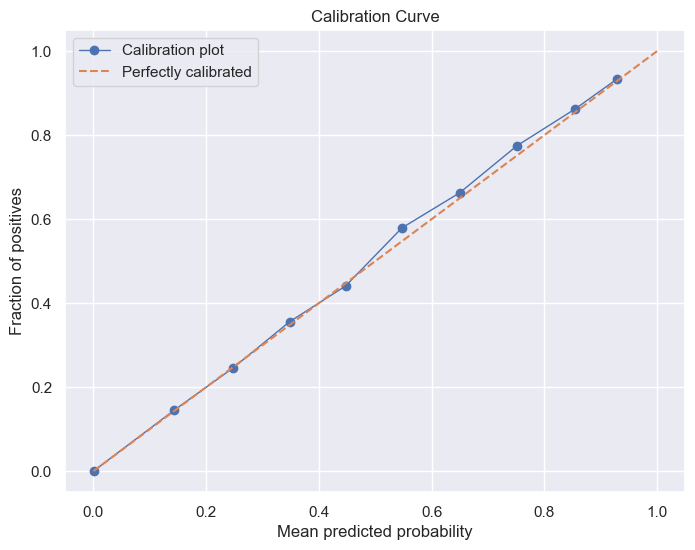

In [68]:
import xgboost as xgb

xgboost = xgb.XGBClassifier(max_depth=3, random_state=42, use_label_encoder=False, eval_metric='logloss')
calibrated_xgboost_probas = eval_model_calibrated(training_data, X_columns, y_column, model=xgboost, should_plot=True)

Evaluation of Calibrated Model on calibration set:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    795397
           1       0.77      0.66      0.71      5435

    accuracy                           1.00    800832
   macro avg       0.88      0.83      0.86    800832
weighted avg       1.00      1.00      1.00    800832

Log Loss:
0.008818478424892084
Confusion Matrix:
[[794329   1068]
 [  1829   3606]]


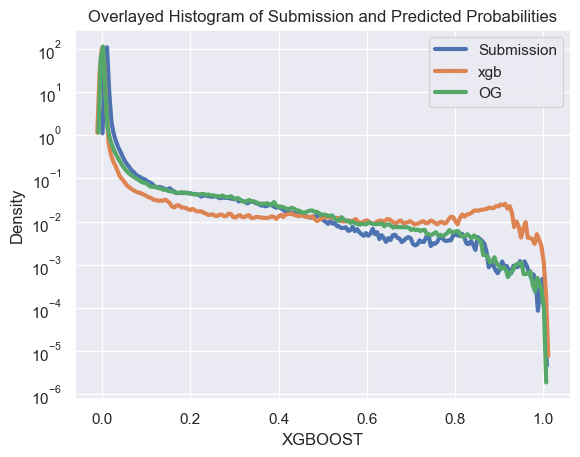

In [69]:
probs = eval_model_calibrated(
    training_data, 
    X_columns, 
    y_column, 
    model=xgboost,
)
training_data['XGBOOST'] = probs

sns.kdeplot(submission, label='Submission', lw=3, alpha=1)
sns.kdeplot(training_data['XGBOOST'], label='xgb', lw=3, alpha=1)
sns.kdeplot(training_data['LOGISTIC_REG'], label='OG', lw=3, alpha=1)
plt.legend()
plt.yscale('log')
plt.legend()
plt.title('Overlayed Histogram of Submission and Predicted Probabilities')
plt.show()



In [ ]:
submission_xgb = create_submission_file(training_data, 'XGBOOST',data_submission_example, filename='./predictions/xgb-2y-exp-no-multicolinearity-lognormal-time-no-dates.csv')

In [70]:
probs = eval_model_calibrated(
    training_data, 
    X_columns, 
    'TARGET_EVENT_BINARY_2Y', 
    model=xgb.XGBClassifier(max_depth=3, random_state=42, use_label_encoder=False, eval_metric='logloss'),
)
training_data['XGBOOST_2Y'] = probs

Evaluation of Calibrated Model on calibration set:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    795397
           1       0.77      0.66      0.71      5435

    accuracy                           1.00    800832
   macro avg       0.88      0.83      0.86    800832
weighted avg       1.00      1.00      1.00    800832

Log Loss:
0.008818478424892084
Confusion Matrix:
[[794329   1068]
 [  1829   3606]]


In [71]:
probs = eval_model_calibrated(
    training_data, 
    X_columns, 
    'TARGET_EVENT_BINARY_1Y', 
    model=xgb.XGBClassifier(max_depth=3, random_state=42, use_label_encoder=False, eval_metric='logloss'),
)
training_data['XGBOOST_1Y'] = probs

Evaluation of Calibrated Model on calibration set:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    795397
           1       0.77      0.66      0.71      5435

    accuracy                           1.00    800832
   macro avg       0.88      0.83      0.86    800832
weighted avg       1.00      1.00      1.00    800832

Log Loss:
0.008818478424892084
Confusion Matrix:
[[794329   1068]
 [  1829   3606]]


In [72]:
probs = probs = eval_model_calibrated(
    training_data, 
    X_columns, 
    'TARGET_EVENT_BINARY_6M', 
    model=xgb.XGBClassifier(max_depth=3, random_state=42, use_label_encoder=False, eval_metric='logloss'),
)
training_data['XGBOOST_6M'] = probs

Evaluation of Calibrated Model on calibration set:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    795397
           1       0.77      0.66      0.71      5435

    accuracy                           1.00    800832
   macro avg       0.88      0.83      0.86    800832
weighted avg       1.00      1.00      1.00    800832

Log Loss:
0.008818478424892084
Confusion Matrix:
[[794329   1068]
 [  1829   3606]]


In [73]:
training_data['XGBOOST_6M'].describe()

count    1.601663e+06
mean     6.789107e-03
std      6.365851e-02
min      0.000000e+00
25%      0.000000e+00
50%      4.331958e-06
75%      9.935298e-06
max      1.000000e+00
Name: XGBOOST_6M, dtype: float64

In [74]:
training_data['XGBOOST_2Y'].describe()

count    1.601663e+06
mean     6.789107e-03
std      6.365851e-02
min      0.000000e+00
25%      0.000000e+00
50%      4.331958e-06
75%      9.935298e-06
max      1.000000e+00
Name: XGBOOST_2Y, dtype: float64

In [28]:
eval_model(training_data, X_columns, 'TARGET_EVENT_BINARY_2Y', model1=xgb.XGBClassifier(max_depth=3, random_state=42, use_label_encoder=False, eval_metric='logloss'))

Evaluation of Model 1 on df2:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    795431
           1       0.78      0.66      0.71      5401

    accuracy                           1.00    800832
   macro avg       0.89      0.83      0.86    800832
weighted avg       1.00      1.00      1.00    800832

Log Loss:
0.008855552410560243
Confusion Matrix:
[[794415   1016]
 [  1835   3566]]


0.008855552410560243

In [77]:
for magic_number in np.linspace(0.2, 0.7, 10):
    print(magic_number)
    experiment_probs = calculate_probabilities(training_data, 'XGBOOST_6M', magic_number)
    print(experiment_probs.mean(), experiment_probs.max(), experiment_probs.min(), experiment_probs.std())
    training_data['XGBOOST_2Y_EXPERIMENT_PROBS'] = experiment_probs
    submission_exp = create_submission_file(training_data, 'XGBOOST_2Y_EXPERIMENT_PROBS', data_submission_example, filename='./predictions/xgboost-prediction-with-time-param-tmp.csv')

0.2
0.01640392046805991 1.0 0.0 0.1114603968637478
Before centering:
1.000032357827075 0.0 0.01259405877182652
Centering probabilities...
1.0 0.002209903515051922 0.01480000000000001
Saved file: ./predictions/xgboost-prediction-with-time-param-tmp.csv
0.25555555555555554
0.015236489757785675 1.0 0.0 0.1073186749527252
Before centering:
1.000032357827057 0.0 0.011256880311315927
Centering probabilities...
1.0 0.0035479312241155914 0.014799999999999995
Saved file: ./predictions/xgboost-prediction-with-time-param-tmp.csv
0.3111111111111111
0.014341073250045031 1.0 0.0 0.1039436122753474
Before centering:
1.0000323578218964 0.0 0.010254668398643866
Centering probabilities...
1.0 0.004550078724443686 0.014799999999999995
Saved file: ./predictions/xgboost-prediction-with-time-param-tmp.csv
0.3666666666666667
0.013616582387918408 1.0 0.0 0.10106210077629024
Before centering:
1.0000323575614989 0.0 0.009462466311674468
Centering probabilities...
1.0 0.005341896735183257 0.014800000000000006
Sa

0.016656496046865088 1.0 0.0 0.11232344140282355


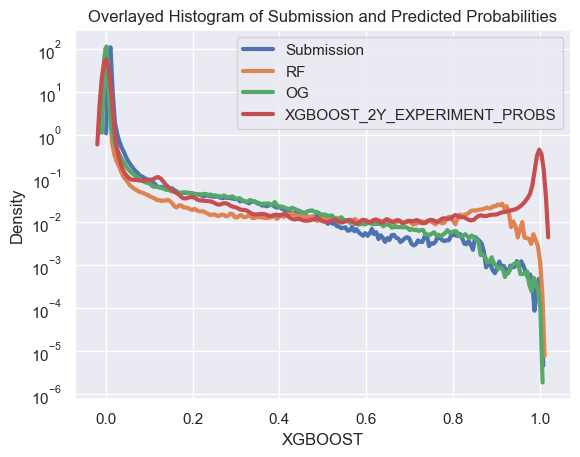

In [78]:
experiment_probs = calculate_probabilities(training_data, 'XGBOOST_6M', 0.19)
print(experiment_probs.mean(), experiment_probs.max(), experiment_probs.min(), experiment_probs.std())
training_data['XGBOOST_2Y_EXPERIMENT_PROBS'] = experiment_probs

sns.kdeplot(submission, label='Submission', lw=3, alpha=1)
sns.kdeplot(training_data['XGBOOST'], label='RF', lw=3, alpha=1)
sns.kdeplot(training_data['LOGISTIC_REG'], label='OG', lw=3, alpha=1)
sns.kdeplot(training_data['XGBOOST_2Y_EXPERIMENT_PROBS'], label='XGBOOST_2Y_EXPERIMENT_PROBS', lw=3, alpha=1)
plt.legend()
plt.yscale('log')
plt.legend()
plt.title('Overlayed Histogram of Submission and Predicted Probabilities')
plt.show()
# Uncalibrated 0.01793455 1.0 1.847744e-06 0.113131166


In [79]:
submission_xgb = create_submission_file(training_data, 'XGBOOST_2Y_EXPERIMENT_PROBS',data_submission_example, filename='./predictions/xgb-exp-fixed-magic-number-19.csv')

Before centering:
1.0000323578270751 0.0 0.012887052705712216
Centering probabilities...
1.0 0.001916544554600448 0.01480000000000001
Saved file: ./predictions/xgb-exp-fixed-magic-number-19.csv


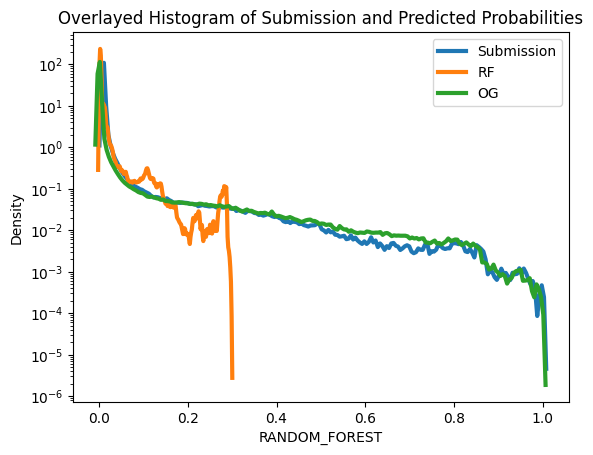

Before centering:
0.8770924231462338 0.0012896586472200822 0.008047223228945155
Centering probabilities...
0.8838451999172886 0.008042435418274927 0.01479999999999999
Saved file: ./predictions/random-forrest-2y-exp-no-multicolinearity-lognormal-time-no-dates.csv


In [ ]:
probs = train_and_predict_two_halves(
    training_data, 
    X_columns, 
    y_column, 
    model1=RandomForestClassifier(n_estimators=50, max_depth=3, random_state=42),
)
training_data['RANDOM_FOREST'] = probs

sns.kdeplot(submission, label='Submission', lw=3, alpha=1)
sns.kdeplot(training_data['RANDOM_FOREST'], label='RF', lw=3, alpha=1)
sns.kdeplot(training_data['LOGISTIC_REG'], label='OG', lw=3, alpha=1)
plt.legend()
plt.yscale('log')
plt.legend()
plt.title('Overlayed Histogram of Submission and Predicted Probabilities')
plt.show()

submission_rf = create_submission_file(training_data, 'RANDOM_FOREST',data_submission_example, filename='./predictions/random-forrest-2y-exp-no-multicolinearity-lognormal-time-no-dates.csv')

In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier

models =  [
    (LogisticRegression(max_iter=400, penalty=None, C=1.0, random_state=42),
     LogisticRegression(max_iter=400, penalty=None, C=1.0, random_state=42)),
    
   (LogisticRegression(max_iter=400, penalty=None, C=0.5, random_state=42),
     LogisticRegression(max_iter=400, penalty=None, C=0.5, random_state=42)),
]

best_logloss = 100
best_models = None
for model in models:

    logloss = test_model_2y_1y(
        training_data, 
        X_columns, 
        'TARGET_EVENT_BINARY_1Y',
        model1=model[0],
        model2=model[1],
    )
    if logloss < best_logloss:
        best_logloss = logloss
        best_models = model
    print(model[0])
    print('Logloss is ', logloss)
    print('-----------------------------------------')

c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Evaluation of Model 1 on df2:
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    509478
           1       0.60      0.39      0.47      5071

    accuracy                           0.99    514549
   macro avg       0.79      0.69      0.73    514549
weighted avg       0.99      0.99      0.99    514549

Log Loss:
0.020154686217490652
Confusion Matrix:
[[508136   1342]
 [  3093   1978]]
Evaluation of Model 2 on df1:
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    509480
           1       0.60      0.40      0.48      5069

    accuracy                           0.99    514549
   macro avg       0.80      0.70      0.74    514549
weighted avg       0.99      0.99      0.99    514549

Log Loss:
0.02041090972095113
Confusion Matrix:
[[508121   1359]
 [  3032   2037]]
Centering probabilities...
1.0 0.0027108450789681583 0.014800000000000004

c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\takat\AppData\Local\Programs\Python

Evaluation of Model 1 on df2:
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    509478
           1       0.60      0.39      0.47      5071

    accuracy                           0.99    514549
   macro avg       0.79      0.69      0.73    514549
weighted avg       0.99      0.99      0.99    514549

Log Loss:
0.020154686217490652
Confusion Matrix:
[[508136   1342]
 [  3093   1978]]
Evaluation of Model 2 on df1:
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    509480
           1       0.60      0.40      0.48      5069

    accuracy                           0.99    514549
   macro avg       0.80      0.70      0.74    514549
weighted avg       0.99      0.99      0.99    514549

Log Loss:
0.02041090972095113
Confusion Matrix:
[[508121   1359]
 [  3032   2037]]
Centering probabilities...
1.0 0.0027108450789681583 0.014800000000000004

In [ ]:
groups_by_size = {}

# Initialize a dictionary to hold covariance matrices by group size
cov_matrices_by_size = {}

# Group by 'BORROWER_ID' and iterate through the first 100 groups
for idx, (name, group) in enumerate(training_data.groupby('BORROWER_ID')):
    if idx % 100 == 0: 
        print('At index', idx)
        
    if idx == 50000:
        break
    
    # Sort the group by CONTRACT_DATE_OF_LOAN_AGREEMENT
    group = group.sort_values(by='CONTRACT_DATE_OF_LOAN_AGREEMENT')
    
    group_size = len(group)
    if group_size not in groups_by_size:
        groups_by_size[group_size] = []
        
    groups_by_size[group_size].append(group)

# Initialize a new dictionary to hold the merged DataFrames by size
merged_groups_by_size = {}

for size, dfs in groups_by_size.items():
    # Merge all DataFrames of the same size into a single DataFrame
    merged_df = pd.concat(dfs, ignore_index=True)
    # Store the merged DataFrame in the new dictionary
    merged_groups_by_size[size] = merged_df

# Now, merged_groups_by_size contains the merged DataFrames categorized by group size


In [ ]:
import json
import numpy as np
import pandas as pd

# Your code to generate groups_by_size and merged_groups_by_size

cov_matrices_by_size = {}

for size, merged_df in merged_groups_by_size.items():
    if size > 1:  # Covariance matrix for single-element arrays doesn't make sense
        try:
            cov_matrix = np.cov(merged_df['TARGET_EVENT_BINARY'].values.reshape(size,-1))
            if not np.isnan(cov_matrix).any():  # Check for NaN values
                cov_matrices_by_size[size] = cov_matrix.tolist()  # Convert numpy array to list for JSON serialization
        except Exception as e:
            print(f"An error occurred while calculating the covariance matrix for size {size}: {e}")

# Ensure that the dictionary contains only JSON-serializable items
serializable_cov_matrices_by_size = {k: v.tolist() if isinstance(v, np.ndarray) else v for k, v in cov_matrices_by_size.items()}

# Save to JSON
with open('./data/cov_matrices_by_size.json', 'w') as f:
    json.dump(serializable_cov_matrices_by_size, f)


C:\Users\takat\AppData\Local\Temp\ipykernel_13332\2391036120.py:12: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov_matrix = np.cov(merged_df['TARGET_EVENT_BINARY'].values.reshape(size,-1))
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [ ]:
cov_matrices_by_size

{2: [[0.005868589752778426, -3.2357827075016176e-05],
  [-3.2357827075016176e-05, 0.005451716043799604]],
 3: [[0.007337144521720125, -2.6009019928111114e-05, -2.6009019928111046e-05],
  [-2.6009019928111114e-05, 0.003507502116019551, -1.2385247584814735e-05],
  [-2.6009019928111046e-05, -1.2385247584814735e-05, 0.003507502116019557]],
 4: [[0.0023364421983921592,
   -1.3695440787761734e-05,
   -5.478176315104693e-06,
   -8.217264472657053e-06],
  [-1.3695440787761734e-05,
   0.005820562334798763,
   -1.3695440787761748e-05,
   -2.054316118164268e-05],
  [-5.478176315104693e-06,
   -1.3695440787761748e-05,
   0.0023364421983921558,
   -8.217264472657026e-06],
  [-8.217264472657053e-06,
   -2.054316118164268e-05,
   -8.217264472657026e-06,
   0.003500554665351909]],
 8: [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 

In [ ]:
# Save to JSON
import json

with open('cov_matrices_by_size.json', 'w') as f:
    json.dump(cov_matrices_by_size, f)